In [1]:
!nvidia-smi

Sun Jun  6 13:08:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   45C    P0    60W / 149W |    354MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [3]:
# Hier kann das Spiel übergeben werden
game = "Pong-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [4]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [6]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [7]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [9]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

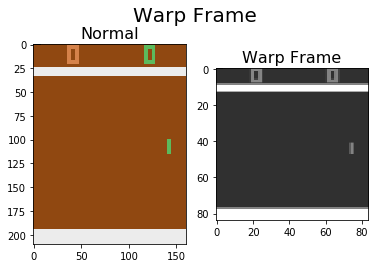

In [10]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [11]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

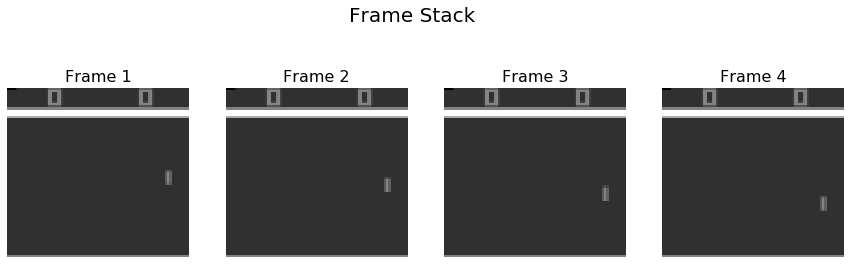

In [12]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
    axs[i].axis("off")
plt.show()

### Erstellen des Environments

In [13]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)


""" saving the properties for csv """
MODE = "NoEpisodicLife_NoClipReward_PRETRAINED_w_EpisodicLife"
PATH = "WEIGHTS/" + game + "/" + MODE + "/"
print(PATH)

WEIGHTS/Pong-v0/NoEpisodicLife_NoClipReward_PRETRAINED_w_EpisodicLife/


# **Convolutional Neural Network**

In [14]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "categorical_crossentropy"
OPTIMIZER = RMSprop(learning_rate=0.000025, rho=0.95, epsilon=0.01)

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="valid")(net_input)
    x = Activation("relu")(x)
    #x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="valid")(x)
    #x = Activation("relu")(x)
    #x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid")(x)
    #x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512, kernel_initializer='he_uniform')(x)
    x = Activation("relu")(x)
    x = Dense(env.action_space.n, kernel_initializer='he_uniform')(x)
    net_output = Activation("softmax")(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Agent Network
CNN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

## Aktion wählen

In [15]:
def get_action(state):
    policy = CNN.predict(state)[0]
    action = np.random.choice(env.action_space.n, p=policy)
    return action

## Discount Rewards

In [16]:
def discount_rewards(REWARDS):
    gamma = 0.99
    running_add = 0
    discounted_r = np.zeros_like(REWARDS)
    for i in reversed(range(0, len(REWARDS))):
        if REWARDS[i] != 0:
            running_add = 0
        running_add = running_add * gamma + REWARDS[i]
        discounted_r[i] = running_add
        
    discounted_r -= np.mean(discounted_r)
    discounted_r /= np.std(discounted_r)

    return discounted_r

In [17]:
def append_sample(state, action, reward):
    STATES.append(state)
    action_onehot = np.zeros([env.action_space.n])
    action_onehot[action] = 1
    ACTIONS.append(action_onehot)
    REWARDS.append(reward)

## Update Policy

In [18]:
def update_policy(STATES, ACTIONS, REWARDS):
    states = np.vstack(STATES)
    actions = np.vstack(ACTIONS)
    
    # discount rewards
    discounted_r = discount_rewards(REWARDS)
    
    # training
    CNN.fit(states, actions, sample_weight=discounted_r, epochs=1, verbose=0)
    
    # leeren des Episoden Buffers
    STATES, ACTIONS, REWARDS = [], [], []

# Trainings des Agenten

In [19]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

-21.0

In [ ]:
EPISODES = 15_000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
STATES, ACTIONS, REWARDS = [], [], []

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # Transition zwischenspeichern
        append_sample(state, action, reward)
        
        # State aktualisieren
        state = next_state

        if done:
            update_policy(STATES, ACTIONS, REWARDS)
            STATES, ACTIONS, REWARDS = [], [], []
            
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD)

            # Übernahme des höchsten Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward

                import os
                try:
                    os.makedirs(PATH)
                except FileExistsError:
                    # Pfad existiert bereits
                    pass
                CNN.save_weights(PATH +"Best.h5")

W0606 13:08:40.778813 139852655957824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 1 	Reward: -21.0 	Mean: -21.0 	BestMean: -21.0
Episode: 2 	Reward: -21.0 	Mean: -21.0 	BestMean: -21.0
Episode: 3 	Reward: -21.0 	Mean: -21.0 	BestMean: -21.0
Episode: 4 	Reward: -21.0 	Mean: -21.0 	BestMean: -21.0
Episode: 5 	Reward: -20.0 	Mean: -20.8 	BestMean: -21.0
Episode: 6 	Reward: -20.0 	Mean: -20.67 	BestMean: -20.8
Episode: 7 	Reward: -21.0 	Mean: -20.71 	BestMean: -20.666666666666668
Episode: 8 	Reward: -20.0 	Mean: -20.62 	BestMean: -20.666666666666668
Episode: 9 	Reward: -21.0 	Mean: -20.67 	BestMean: -20.625
Episode: 10 	Reward: -20.0 	Mean: -20.6 	BestMean: -20.625
Episode: 11 	Reward: -20.0 	Mean: -20.5 	BestMean: -20.6
Episode: 12 	Reward: -21.0 	Mean: -20.5 	BestMean: -20.5
Episode: 13 	Reward: -21.0 	Mean: -20.5 	BestMean: -20.5
Episode: 14 	Reward: -20.0 	Mean: -20.4 	BestMean: -20.5
Episode: 15 	Reward: -19.0 	Mean: -20.3 	BestMean: -20.4
Episode: 16 	Reward: -21.0 	Mean: -20.4 	BestMean: -20.3
Episode: 17 	Reward: -21.0 	Mean: -20.4 	BestMean: -20.3
Epis

Episode: 144 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.8
Episode: 145 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.8
Episode: 146 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.8
Episode: 147 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.8
Episode: 148 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.8
Episode: 149 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.8
Episode: 150 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.8
Episode: 151 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.8
Episode: 152 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.8
Episode: 153 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.8
Episode: 154 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.8
Episode: 155 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.8
Episode: 156 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.8
Episode: 157 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.8
Episode: 158 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.8
Episode: 159 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.8
Episode: 160 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.8
Episode: 161 	

Episode: 286 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 287 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.8
Episode: 288 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.8
Episode: 289 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.8
Episode: 290 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 291 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 292 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 293 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 294 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 295 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 296 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.8
Episode: 297 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.8
Episode: 298 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.8
Episode: 299 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.8
Episode: 300 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.8
Episode: 301 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.8
Episode: 302 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.8
Episode: 303 	

Episode: 428 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 429 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 430 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.8
Episode: 431 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.8
Episode: 432 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.8
Episode: 433 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.8
Episode: 434 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.8
Episode: 435 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.8
Episode: 436 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.8
Episode: 437 	Reward: -18.0 	Mean: -20.2 	BestMean: -19.8
Episode: 438 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.8
Episode: 439 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.8
Episode: 440 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.8
Episode: 441 	Reward: -18.0 	Mean: -19.7 	BestMean: -19.8
Episode: 442 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.7
Episode: 443 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.7
Episode: 444 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.7
Episode: 445 	

Episode: 570 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.7
Episode: 571 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 572 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.7
Episode: 573 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 574 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 575 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 576 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 577 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 578 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.7
Episode: 579 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 580 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.7
Episode: 581 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.7
Episode: 582 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 583 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.7
Episode: 584 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 585 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.7
Episode: 586 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 587 	

Episode: 712 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.7
Episode: 713 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.7
Episode: 714 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.7
Episode: 715 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.7
Episode: 716 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.7
Episode: 717 	Reward: -19.0 	Mean: -19.7 	BestMean: -19.7
Episode: 718 	Reward: -21.0 	Mean: -19.7 	BestMean: -19.7
Episode: 719 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.7
Episode: 720 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.7
Episode: 721 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.7
Episode: 722 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.7
Episode: 723 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.7
Episode: 724 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.7
Episode: 725 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 726 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 727 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 728 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.7
Episode: 729 	

Episode: 854 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 855 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 856 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 857 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 858 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 859 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 860 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 861 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 862 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 863 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 864 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 865 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 866 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 867 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 868 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 869 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 870 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 871 	

Episode: 996 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 997 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 998 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 999 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1000 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1001 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1002 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1003 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1004 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1005 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1006 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1007 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1008 	Reward: -19.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1009 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1010 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1011 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1012 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
E

Episode: 1135 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1136 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1137 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1138 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1139 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1140 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1141 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1142 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1143 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.7
Episode: 1144 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 1145 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 1146 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 1147 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1148 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1149 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1150 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.7
Episode: 1151 	Reward: -21.0 	Mean: -20.4 	BestMean: -19

Episode: 1274 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1275 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1276 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1277 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1278 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1279 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1280 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1281 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1282 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1283 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1284 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1285 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1286 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1287 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1288 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1289 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1290 	Reward: -21.0 	Mean: -20.7 	BestMean: -19

Episode: 1413 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1414 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1415 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.7
Episode: 1416 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 1417 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 1418 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1419 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1420 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1421 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1422 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1423 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1424 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1425 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1426 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1427 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1428 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1429 	Reward: -21.0 	Mean: -20.9 	BestMean: -19

Episode: 1552 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1553 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1554 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1555 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1556 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1557 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1558 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1559 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1560 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1561 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1562 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1563 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1564 	Reward: -19.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1565 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1566 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1567 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1568 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 1691 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1692 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1693 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1694 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1695 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1696 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1697 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1698 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1699 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1700 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1701 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1702 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1703 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1704 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1705 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1706 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1707 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 1830 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1831 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 1832 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1833 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 1834 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1835 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1836 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1837 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1838 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1839 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1840 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1841 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1842 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1843 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1844 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 1845 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1846 	Reward: -21.0 	Mean: -20.9 	BestMean: -19

Episode: 1969 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1970 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1971 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1972 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1973 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1974 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1975 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 1976 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1977 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1978 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1979 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1980 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 1981 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1982 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1983 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1984 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 1985 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 2108 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.7
Episode: 2109 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 2110 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 2111 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 2112 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2113 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2114 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2115 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2116 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2117 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2118 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2119 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2120 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2121 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2122 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2123 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2124 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 2247 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.7
Episode: 2248 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2249 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2250 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2251 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2252 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2253 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2254 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2255 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2256 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2257 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2258 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2259 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2260 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2261 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2262 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2263 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 2386 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2387 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2388 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2389 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2390 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2391 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2392 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2393 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2394 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2395 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2396 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2397 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2398 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2399 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2400 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2401 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2402 	Reward: -20.0 	Mean: -20.5 	BestMean: -19

Episode: 2525 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.7
Episode: 2526 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.7
Episode: 2527 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2528 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2529 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2530 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2531 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2532 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2533 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2534 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2535 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2536 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2537 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2538 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2539 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2540 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2541 	Reward: -21.0 	Mean: -20.7 	BestMean: -19

Episode: 2664 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 2665 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 2666 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 2667 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 2668 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 2669 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 2670 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2671 	Reward: -18.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2672 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2673 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2674 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2675 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2676 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2677 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2678 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.7
Episode: 2679 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 2680 	Reward: -21.0 	Mean: -20.4 	BestMean: -19

Episode: 2803 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 2804 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2805 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2806 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2807 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2808 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2809 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2810 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2811 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2812 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2813 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2814 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2815 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2816 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2817 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2818 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2819 	Reward: -21.0 	Mean: -20.6 	BestMean: -19

Episode: 2942 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 2943 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2944 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2945 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2946 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2947 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2948 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 2949 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 2950 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2951 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2952 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2953 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 2954 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2955 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2956 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2957 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 2958 	Reward: -21.0 	Mean: -20.9 	BestMean: -19

Episode: 3081 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3082 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3083 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3084 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3085 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3086 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3087 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3088 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3089 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3090 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3091 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3092 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3093 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3094 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3095 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3096 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3097 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 3220 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3221 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3222 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3223 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3224 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3225 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3226 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3227 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3228 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3229 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3230 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3231 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3232 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3233 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3234 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3235 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3236 	Reward: -20.0 	Mean: -20.5 	BestMean: -19

Episode: 3359 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3360 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3361 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.7
Episode: 3362 	Reward: -18.0 	Mean: -20.3 	BestMean: -19.7
Episode: 3363 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.7
Episode: 3364 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 3365 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 3366 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 3367 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 3368 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 3369 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 3370 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 3371 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 3372 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3373 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3374 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3375 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 3498 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3499 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3500 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3501 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3502 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3503 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3504 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 3505 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 3506 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 3507 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3508 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3509 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3510 	Reward: -18.0 	Mean: -20.3 	BestMean: -19.7
Episode: 3511 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 3512 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 3513 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3514 	Reward: -20.0 	Mean: -20.6 	BestMean: -19

Episode: 3637 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3638 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3639 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3640 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3641 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3642 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3643 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3644 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3645 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3646 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3647 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 3648 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3649 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3650 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3651 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3652 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3653 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 3776 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3777 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3778 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3779 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3780 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3781 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3782 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3783 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3784 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3785 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3786 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3787 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3788 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3789 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3790 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3791 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3792 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 3915 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.7
Episode: 3916 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 3917 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 3918 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 3919 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 3920 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3921 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 3922 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3923 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 3924 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3925 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3926 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 3927 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3928 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3929 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3930 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 3931 	Reward: -21.0 	Mean: -20.9 	BestMean: -19

Episode: 4054 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4055 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4056 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.7
Episode: 4057 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 4058 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 4059 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 4060 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 4061 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 4062 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4063 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4064 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4065 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4066 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 4067 	Reward: -19.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4068 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4069 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4070 	Reward: -21.0 	Mean: -20.8 	BestMean: -19

Episode: 4193 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4194 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4195 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4196 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4197 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4198 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4199 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4200 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4201 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4202 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4203 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4204 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4205 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4206 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4207 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4208 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4209 	Reward: -20.0 	Mean: -20.7 	BestMean: -19

Episode: 4332 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4333 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4334 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4335 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4336 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4337 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4338 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4339 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4340 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4341 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4342 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4343 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4344 	Reward: -19.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4345 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4346 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4347 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4348 	Reward: -21.0 	Mean: -20.7 	BestMean: -19

Episode: 4471 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 4472 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4473 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4474 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4475 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4476 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4477 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4478 	Reward: -19.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4479 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4480 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4481 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4482 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4483 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.7
Episode: 4484 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 4485 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.7
Episode: 4486 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 4487 	Reward: -21.0 	Mean: -20.4 	BestMean: -19

Episode: 4610 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4611 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4612 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4613 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4614 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4615 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4616 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4617 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4618 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4619 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4620 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4621 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4622 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4623 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4624 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4625 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4626 	Reward: -20.0 	Mean: -20.8 	BestMean: -19

Episode: 4749 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4750 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4751 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 4752 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 4753 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4754 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4755 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 4756 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4757 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4758 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4759 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4760 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 4761 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4762 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4763 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4764 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 4765 	Reward: -17.0 	Mean: -20.4 	BestMean: -19

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Episode: 9225 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9226 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9227 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9228 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 9229 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9230 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9231 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9232 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9233 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9234 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9235 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9236 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9237 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9238 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9239 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 9240 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 9241 	Reward: -21.0 	Mean: -20.9 	BestMean: -19

Episode: 9364 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 9365 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 9366 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 9367 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 9368 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9369 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9370 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9371 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9372 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9373 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9374 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.7
Episode: 9375 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9376 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9377 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.7
Episode: 9378 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9379 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9380 	Reward: -21.0 	Mean: -20.7 	BestMean: -19

Episode: 9503 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9504 	Reward: -18.0 	Mean: -20.3 	BestMean: -19.7
Episode: 9505 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9506 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9507 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 9508 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9509 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 9510 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 9511 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 9512 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9513 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9514 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9515 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9516 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9517 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9518 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 9519 	Reward: -21.0 	Mean: -20.9 	BestMean: -19

Episode: 9642 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9643 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9644 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9645 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9646 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9647 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9648 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9649 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9650 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9651 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9652 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9653 	Reward: -18.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9654 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9655 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9656 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9657 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9658 	Reward: -20.0 	Mean: -20.5 	BestMean: -19

Episode: 9781 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9782 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9783 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9784 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9785 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9786 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9787 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9788 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9789 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9790 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9791 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9792 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9793 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 9794 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9795 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9796 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 9797 	Reward: -21.0 	Mean: -20.9 	BestMean: -19

Episode: 9920 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 9921 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 9922 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9923 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 9924 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.7
Episode: 9925 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.7
Episode: 9926 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 9927 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 9928 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 9929 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9930 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 9931 	Reward: -17.0 	Mean: -20.3 	BestMean: -19.7
Episode: 9932 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 9933 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 9934 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9935 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 9936 	Reward: -21.0 	Mean: -20.6 	BestMean: -19

Episode: 10058 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10059 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10060 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10061 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10062 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10063 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10064 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10065 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10066 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10067 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10068 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10069 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 10070 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10071 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10072 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10073 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10074 	Reward: -19.0 	Mean: -20

Episode: 10195 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10196 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10197 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10198 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10199 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10200 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10201 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10202 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10203 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10204 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10205 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10206 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10207 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10208 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10209 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10210 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10211 	Reward: -21.0 	Mean: -20

Episode: 10332 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10333 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10334 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10335 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10336 	Reward: -18.0 	Mean: -20.4 	BestMean: -19.7
Episode: 10337 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 10338 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 10339 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 10340 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.7
Episode: 10341 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 10342 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10343 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10344 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10345 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10346 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10347 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10348 	Reward: -21.0 	Mean: -20

Episode: 10469 	Reward: -18.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10470 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10471 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10472 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10473 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10474 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10475 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10476 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 10477 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.7
Episode: 10478 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.7
Episode: 10479 	Reward: -17.0 	Mean: -19.8 	BestMean: -19.7
Episode: 10480 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.7
Episode: 10481 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.7
Episode: 10482 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.7
Episode: 10483 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.7
Episode: 10484 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.7
Episode: 10485 	Reward: -21.0 	Mean: -19

Episode: 10606 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10607 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10608 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10609 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10610 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10611 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10612 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10613 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10614 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10615 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10616 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10617 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10618 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10619 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10620 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10621 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10622 	Reward: -19.0 	Mean: -20

Episode: 10743 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10744 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10745 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10746 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10747 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10748 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10749 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10750 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10751 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10752 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10753 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10754 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10755 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10756 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10757 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 10758 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 10759 	Reward: -21.0 	Mean: -20

Episode: 10880 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 10881 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10882 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10883 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10884 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10885 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10886 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 10887 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 10888 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10889 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10890 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 10891 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10892 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 10893 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10894 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 10895 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 10896 	Reward: -21.0 	Mean: -20

Episode: 11017 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11018 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11019 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11020 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11021 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11022 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 11023 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 11024 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 11025 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 11026 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 11027 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 11028 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 11029 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11030 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11031 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11032 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11033 	Reward: -21.0 	Mean: -20

Episode: 11154 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11155 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11156 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11157 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11158 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11159 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11160 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.7
Episode: 11161 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11162 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11163 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 11164 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 11165 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11166 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11167 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11168 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11169 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11170 	Reward: -21.0 	Mean: -20

Episode: 11291 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 11292 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11293 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11294 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11295 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 11296 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.7
Episode: 11297 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 11298 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 11299 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 11300 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11301 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11302 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 11303 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.7
Episode: 11304 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11305 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11306 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11307 	Reward: -21.0 	Mean: -20

Episode: 11428 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11429 	Reward: -18.0 	Mean: -20.5 	BestMean: -19.7
Episode: 11430 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11431 	Reward: -17.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11432 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11433 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11434 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11435 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11436 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.7
Episode: 11437 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.7
Episode: 11438 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.7
Episode: 11439 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 11440 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.7
Episode: 11441 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.7
Episode: 11442 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11443 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11444 	Reward: -18.0 	Mean: -20

Episode: 11565 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11566 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11567 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11568 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.7
Episode: 11569 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.7
Episode: 11570 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.7
Episode: 11571 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.7
Episode: 11572 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.7
Episode: 11573 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.7
Episode: 11574 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11575 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11576 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11577 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11578 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.7
Episode: 11579 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.7
Episode: 11580 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.7
Episode: 11581 	Reward: -21.0 	Mean: -20

Episode: 11702 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.6
Episode: 11703 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.6
Episode: 11704 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.6
Episode: 11705 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.6
Episode: 11706 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11707 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.6
Episode: 11708 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.6
Episode: 11709 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.6
Episode: 11710 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11711 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11712 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.6
Episode: 11713 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11714 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11715 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11716 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11717 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 11718 	Reward: -21.0 	Mean: -20

Episode: 11839 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.6
Episode: 11840 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.6
Episode: 11841 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.6
Episode: 11842 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.6
Episode: 11843 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.6
Episode: 11844 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.6
Episode: 11845 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.6
Episode: 11846 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.6
Episode: 11847 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.6
Episode: 11848 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.6
Episode: 11849 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.6
Episode: 11850 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.6
Episode: 11851 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.6
Episode: 11852 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.6
Episode: 11853 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.6
Episode: 11854 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.6
Episode: 11855 	Reward: -21.0 	Mean: -20

Episode: 11976 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.6
Episode: 11977 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.6
Episode: 11978 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.6
Episode: 11979 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11980 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11981 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 11982 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 11983 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 11984 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.6
Episode: 11985 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11986 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11987 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11988 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11989 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 11990 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.6
Episode: 11991 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.6
Episode: 11992 	Reward: -21.0 	Mean: -20

Episode: 12113 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 12114 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 12115 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 12116 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 12117 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 12118 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 12119 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 12120 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 12121 	Reward: -19.0 	Mean: -20.8 	BestMean: -19.6
Episode: 12122 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.6
Episode: 12123 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 12124 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.6
Episode: 12125 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.6
Episode: 12126 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.6
Episode: 12127 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.6
Episode: 12128 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.6
Episode: 12129 	Reward: -21.0 	Mean: -20

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Episode: 13616 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 13617 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 13618 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 13619 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 13620 	Reward: -21.0 	Mean: -21.0 	BestMean: -19.6
Episode: 13621 	Reward: -20.0 	Mean: -20.9 	BestMean: -19.6
Episode: 13622 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 13623 	Reward: -21.0 	Mean: -20.9 	BestMean: -19.6
Episode: 13624 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.6
Episode: 13625 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.6
Episode: 13626 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.6
Episode: 13627 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.6
Episode: 13628 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.6
Episode: 13629 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.6
Episode: 13630 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.6
Episode: 13631 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.6
Episode: 13632 	Reward: -21.0 	Mean: -20

In [22]:
import pandas as pd
from datetime import datetime
date = datetime.now().date()

df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST)), 
               columns =['Rewards', 'Mean Reward']) 
df.to_csv(PATH + game + "_" + str(date) + "_"+ MODE + ".csv", mode="w", index=False)

In [23]:
CNN.save_weights(PATH +"End.h5")